## Texture vs Shape: introduction
(homework #2 for DNN 2024/25)

<div style="max-width: 60em">

In this homework, we will look at a modern residual convolutional net. While they perform very well on image classification tasks, some problems they commonly have are that:<br>
* they rely too much on small-scale features (textures) rather than large-scale ones (shape). This often generalizes poorly to unseen datasets and is less human-aligned (e.g. explanations of why a model chose this class may be less interpretable).
* they are very susceptible to adversarial images, i.e. inputs maliciously altered in a way that is imperceptible to humans and shouldn't change the classification, but completely fool the model, making it output high probabilities for unrelated classes.

While the two problems are somewhat related, we focus on the first one.
You are given a pre-trained model and datasets, as well as the code for standard evaluation and training loops, and for generating adversarial examples.
Your tasks (fully detailed in later cells) will be as follows:

0. Adapt a pretrained model to the smaller datasets by changing the classification layer.
1. Implement transformations (blur, pixelize, noise) that can help us elucidate and perhaps remedy the texture-bias problem.
2. Compare how the model handles them and how much they help as augmentations used in fine-tuning.
3. Read a paper about AdvProp: a relatively simple method for training models with less texture bias, using adversarial examples; implement and evaluate it.
4. Implement and evaluate SparseTopK: another, even simpler method proposed for the same problem: it just zeroes all but the top 20% activations in some layers.

Submission requirements:
* Please do not modify anything outside of the `### BEGIN SOLUTION ... ### END SOLUTION` blocks (if you feel it might be useful somewhere, ask on slack).
* Please make sure to submit your solution as a notebook with saved cell outputs.
* Don't use `tqdm.notebook` or `tqdm.auto`, just plain `tqdm`.
* It should be possible to execute the notebook from top to bottom when loaded in Colab with a GPU, in a reasonable amount of time.
* Plots should either be images embedded in cell outputs (in a way that shows correctly when loading the notebook from file, without executing it), or attached together with the exported .ipynb notebook in a .zip file  (screenshots are admissible, but prefer exporting with e.g. `plt.savefig()`).

</div>

## Imports

In [1]:
import json
import multiprocessing
from collections.abc import Callable, Iterable, Sequence
from copy import deepcopy
from functools import partial
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import torch
import torch.nn
import torch.nn.functional as F
import torchvision.models
import torch.optim.lr_scheduler
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from tqdm import tqdm

### BEGIN SOLUTION
import torch.nn as nn
from math import ceil
seed = 42
### END SOLUTION

%matplotlib inline

multiprocessing.set_start_method("spawn", force=True)  # Needed when using CUDA.
torch.set_num_threads(8)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    torch.cuda.set_device(2)

_ = torch.manual_seed(42)

## Datasets

In [2]:
%%bash
# 219 MiB
if [ ! -d datasets ]; then
    gdown https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg \
        && tar -xf datasets.tar.gz \
        && rm datasets.tar.gz
fi

# model failed to download, so I needed to download file manually (cell below)

Downloading...
From (original): https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg
From (redirected): https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg&confirm=t&uuid=28344d15-4239-4bae-810b-195ad276b689
To: /content/datasets.tar.gz
100%|██████████| 229M/229M [00:01<00:00, 148MB/s]


In [3]:
# %%bash
# if [[ -f "datasets.tar.gz" ]]; then
#     echo "File exists, extracting..."
#     tar -xf datasets.tar.gz && rm datasets.tar.gz
#     echo "Extraction complete and archive removed."
# else
#     echo "Error: datasets.tar.gz not found!"
#     exit 1
# fi


##### MiniImageNet
MiniImageNet is a downscaled subset of ISVLRC ImageNet-1k<sup>[1]</sup> with only 10 classes (RGB, irregular sizes up to 256x256).
Train/val is a uniformly random split, the parts have 2000/100 images per class, respectively.

We will use the *train* part for fine-tuning and *val* for validation and various evaluation.

[1] https://www.kaggle.com/competitions/imagenet-object-localization-challenge/overview

['bear', 'bicycle', 'boat', 'bottle', 'car', 'cat', 'chair', 'clock', 'elephant', 'truck']


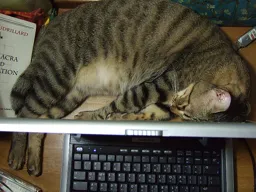

In [4]:
MINI_IMAGENET_PATH = Path("datasets/miniImageNet")
SELECTED_CLASSES = ImageFolder(MINI_IMAGENET_PATH / "train").classes
assert SELECTED_CLASSES == ImageFolder(MINI_IMAGENET_PATH / "val").classes


def example() -> None:  # Note: we scope examples to avoid polluting the global namespace.
    print(SELECTED_CLASSES)
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val")
    img, label = dataset[505]
    display(img)
    print(label, dataset.classes[label])


example()

##### eval_transform, display_image_tensor()

5 cat


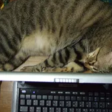

img.shape=torch.Size([3, 112, 112]), img.dtype=torch.float32, min..max=-1.998..2.64
label=5 (cat)


In [5]:
def get_eval_transform() -> v2.Compose:
    """
    The default transform used on all ImageNet images before passing to a model.

    (Typically papers end up with 224x224 images, we make them smaller for speed.)
    """
    return v2.Compose(
        [
            v2.PILToTensor(),
            v2.Resize(size=128, antialias=True),
            v2.CenterCrop(size=(112, 112)),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
        ]
    )


def normalize(x: torch.Tensor) -> torch.Tensor:
    """Normalize an image tensor of shape (*B, C, H, W) from 0..1 values."""
    std = torch.tensor(IMAGENET_DEFAULT_STD, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    mean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    return (x - mean) / std


def unnormalize(x: torch.Tensor) -> torch.Tensor:
    """Revert an image tensor of shape (*B, C, H, W) to 0..1 values."""
    std = torch.tensor(IMAGENET_DEFAULT_STD, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    mean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    return x * std + mean


def display_image_tensor(x: torch.Tensor) -> None:
    """Display a normalized image tensor of shape (C, H, W) as a PIL Image."""
    pil_image: PIL.Image.Image = v2.ToPILImage()(unnormalize(x))
    display(pil_image)


def ceildiv(a: int, b: int) -> int:
    """Return ceil(a /b)."""
    return -(-a // b)


def example() -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[505]
    display_image_tensor(img)
    print(f"{img.shape=}, {img.dtype=}, min..max={img.min().item():.4g}..{img.max().item():.4g}")
    print(f"{label=} ({dataset.classes[label]})")


example()

##### alt_test_dataset
This is a dataset with the same classes and some of the same images, but restylized or otherwise altered to mislead models reliant on textures.
We will use this dataset to test if a training method results in a model that is less reliant on textures.
Note that some alterations are pretty heavy, so the images look very different and it is difficult to achieve more than ~40-50% accuracy.

RGB, 224x224, 280 images per class.

(The dataset was created from https://github.com/bethgelab/model-vs-human/releases/tag/v0.1)

cue-conflict 800, edge 100, low-pass 800, silhouette 100, sketch 500, stylized 500, total 2800


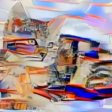

In [6]:
ALT_TEST_DATASET_PATHS = sorted(Path("datasets/testSets").iterdir())
alt_test_dataset = ConcatDataset([ImageFolder(p, transform=get_eval_transform()) for p in ALT_TEST_DATASET_PATHS])


def example() -> None:
    for p in ALT_TEST_DATASET_PATHS:
        dataset = ImageFolder(p, transform=get_eval_transform())
        assert dataset.classes == SELECTED_CLASSES
        print(p.name, len(dataset), end=", ")
        # display_image_tensor(dataset[int(len(dataset) * 0.53)][0])
    print("total", len(alt_test_dataset))

    img, _label = alt_test_dataset[445]
    display_image_tensor(img)


example()

## Evaluate() and get_dataloader()

Here's an implementation of an evaluation loop, to be used in this notebook.

In [7]:
def get_dataloader(
    dataset: Dataset,
    shuffle: bool = False,
    batch_size: int = 256,
    num_workers: int = 2,
    pin_memory: bool = True,
    prefetch_factor: int = 2,
    persistent_workers: bool = True,
    timeout: float = 30.0,
    **kwargs: Any,
) -> DataLoader:
    """DataLoader constructor with different defaults."""
    if num_workers == 0:
        pin_memory = False
        persistent_workers = False
        prefetch_factor = None
        timeout = 0.0

    return DataLoader(
        dataset,
        shuffle=shuffle,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        prefetch_factor=prefetch_factor,
        persistent_workers=persistent_workers,
        timeout=timeout,
        **kwargs,
    )

In [8]:
def evaluate(
    model: torch.nn.Module,
    dataloader: Dataset | DataLoader,
    description: str = "eval",
    device: str = DEVICE,
    quiet: bool = False,
    use_workers: bool = True,
) -> float:
    """Evaluate a model on a dataset or dataloader, returning the accuracy (0..1)."""
    model = model.to(device).eval()
    if not isinstance(dataloader, DataLoader):  # Create from dataset.
        if use_workers:
            dataloader = get_dataloader(dataloader, persistent_workers=False)
        else:
            dataloader = get_dataloader(dataloader, num_workers=0)

    accuracy, n_done, n_correct = 0, 0, 0

    progress_bar = tqdm(dataloader, desc=description, disable=quiet, delay=0.5)
    with torch.no_grad(), progress_bar:
        for image_batch, label_batch in progress_bar:
            logits_batch = model(image_batch.to(device))
            predictions = logits_batch.argmax(dim=1)

            n_done += len(label_batch)
            n_correct += (predictions == label_batch.to(device)).sum().item()
            accuracy = n_correct / n_done if n_done else 0
            progress_bar.set_postfix({"accuracy": f"{accuracy * 100:.1f} %"})

    return accuracy

## Task 0: Model, remapping the classification layer

We will use a ready-made model pretrained on ImageNet-1k.<br>
Since they all output logits for 1000 classes (`IMAGENET_CATEGORIES`),<br>
we need to alter the classification layer to output logits for the 10 MiniImageNet classes instead (`SELECTED_CLASSES`).<br>
Note that several ImageNet-1k classes can map to the same MiniImageNet class.<br>

Your task is to complete the implementation of `remap_output_layer()` below,<br>
so that the model works without any fine-tuning/training of the last layer.<br>
In `example_remapping()` below (which evaluates the model on the val dataset),<br>
you should achieve at least 70% accuracy and finish in under 35 seconds on Colab CPU (~15s on GPU).<br>

In [9]:
SELECTED_MODEL = (torchvision.models.efficientnet_b0, torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)
# 5.3M params, 78% acc@1 on original ImageNet-1k

# Other models we considered, but cut for time:
# * (torchvision.models.mobilenet_v3_small, torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
#     2.5M params, 68% acc@1
# * (torchvision.models.resnet18, torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
#     11.7M params, 70% acc@1 on original ImageNet-1k
# * (torchvision.models.efficientnet_v2_s, torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
#     21.5M params, 84% acc@1

IMAGENET_CATEGORIES = SELECTED_MODEL[1].meta["categories"]
assert IMAGENET_CATEGORIES == torchvision.models.ResNet18_Weights.IMAGENET1K_V1.meta["categories"]
print(len(IMAGENET_CATEGORIES), ", ".join(IMAGENET_CATEGORIES[:7] + ["..."]))

1000 tench, goldfish, great white shark, tiger shark, hammerhead, electric ray, stingray, ...


In [10]:
# Some technical details, feel free to ignore.


def _load_imagenet_id_to_class_id_map(classes: Sequence[str] = SELECTED_CLASSES) -> dict[int, int]:
    """
    Return a map from imagenet ids 0..999 to selected class ids: 0..len(classes)-1.

    Classes should be a subset of the following 16 class names:
        airplane,bear,bicycle,bird,boat,bottle,car,cat,chair,clock,dog,elephant,keyboard,knife,oven,truck
    """
    imagenet_id_to_name = {i: name for i, name in enumerate(IMAGENET_CATEGORIES)}
    class_to_idx = {name: i for i, name in enumerate(classes)}
    with open("datasets/imagenet_name_to_synset_id.json") as f:
        name_to_synset = json.load(f)
    with open("datasets/synset_id_to_class.json") as f:
        synset_to_class = json.load(f)
    # Not all synsets defined in synset_id_to_class.json are present in ImageNet-1k
    # (they also don't appear in our dataset 10-class-ImageNet).
    imagenet_name_to_class_name = {
        name: synset_to_class[synset] for name, synset in name_to_synset.items() if synset in synset_to_class
    }

    result = dict[int, int]()
    for imagenet_id, imagenet_name in imagenet_id_to_name.items():
        # Not all imagenet names are present in 10-class-ImageNet, obviously.
        if imagenet_name in imagenet_name_to_class_name:
            class_name = imagenet_name_to_class_name[imagenet_name]
            # Not all class names defined for 16-class-ImageNet are present in our dataset 10-class-ImageNet.
            if class_name in class_to_idx:
                result[imagenet_id] = class_to_idx[class_name]

    for k, v in result.items():
        assert 0 <= k < len(IMAGENET_CATEGORIES) and 0 <= v < len(classes)

    return result


def _reset_model_weights(model: torch.nn.Module) -> None:
    """Reinitialize the model weights randomly. We probably won't use it."""
    # Some models define reset_parameters(), but unfortunately not all.
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, mode="fan_out")
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        elif isinstance(m, torch.nn.BatchNorm2d | torch.nn.GroupNorm):
            torch.nn.init.ones_(m.weight)
            torch.nn.init.zeros_(m.bias)
        elif isinstance(m, torch.nn.Linear):
            init_range = 1.0 / np.sqrt(m.out_features)
            torch.nn.init.uniform_(m.weight, -init_range, init_range)  # EfficientNet v1
            # torch.nn.init.normal_(m.weight, 0, 0.01)  # MobileNet v3
            torch.nn.init.zeros_(m.bias)

In [11]:
def remap_output_layer(layer: torch.nn.Linear, id_map: dict[int, int]) -> torch.nn.Module:
    """Return a new final classification logit layer where the i-th class becomes id_map[i] instead."""
    assert layer.out_features == len(IMAGENET_CATEGORIES)

    ### BEGIN SOLUTION
    is_bias = layer.bias is not None
    new_out_f = max(id_map.values()) + 1
    new_layer = nn.Linear(layer.in_features, new_out_f, bias = is_bias)
    counts = {key: 0 for key in range(new_out_f)}
    for old_id, new_id in id_map.items():
      new_layer.weight.data[new_id] += layer.weight.data[old_id]
      counts[new_id] += 1
      if is_bias:
        new_layer.bias.data[new_id] += layer.bias.data[old_id]

    # decided to average all weights and biases from coresponding map as
    # an easy way to have contribution of all key->value included.
    for i in range(new_out_f):
      new_layer.weight.data[i] /= counts[i]
      if is_bias:
        new_layer.bias.data[i] /= counts[i]



    return new_layer

    ### END SOLUTION

In [12]:
def get_model(
    eval: bool = False, reset: bool = False, selected_classes: Sequence[str] = SELECTED_CLASSES
) -> torch.nn.Module:
    model_fn, model_weights = SELECTED_MODEL
    model = model_fn(weights=model_weights)

    # Find and replace the last Linear layer.
    id_map = _load_imagenet_id_to_class_id_map(selected_classes)
    last_linear_layer = None
    for parent_module in model.modules():
        for name, layer in parent_module.named_children():
            if isinstance(layer, torch.nn.Linear):
                last_linear_layer = (parent_module, name, layer)
    assert last_linear_layer is not None
    parent_module, name, layer = last_linear_layer

    setattr(parent_module, name, remap_output_layer(layer, id_map))
    if reset:
        _reset_model_weights(model)

    return model.eval() if eval else model.train()


get_model(eval=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 50.2MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
def example_remapping() -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    model = get_model(eval=True)
    evaluate(model, dataset)


example_remapping()

eval: 100%|██████████| 4/4 [00:09<00:00,  2.41s/it, accuracy=90.3 %]


## Training

Here's an implementation of a training loop that we will use for this notebook.
You should not need to alter hyperparameters, use the defaults of `Trainer.__init__()`.

In [14]:
BATCH_NORM_TYPES = (
    torch.nn.BatchNorm1d
    | torch.nn.BatchNorm2d
    | torch.nn.BatchNorm3d
    | torch.nn.SyncBatchNorm
    | torch.nn.LazyBatchNorm1d
    | torch.nn.LazyBatchNorm2d
    | torch.nn.LazyBatchNorm3d
)


class Trainer:
    def __init__(
        self,
        lr: float = 2e-4,
        weight_decay: float = 3e-5,
        batch_norm_momentum: float | None = 0.002,
        n_epochs: int = 10,
        device: str = DEVICE,
        extra_augmentation: v2.Transform | None = None,
        use_workers: bool = True,
    ):
        self.lr = lr
        self.weight_decay = weight_decay
        self.n_epochs = n_epochs
        self.device = device
        self.batch_norm_momentum = batch_norm_momentum
        if extra_augmentation is not None:
            self.extra_augmentation = v2.RandomApply([extra_augmentation], p=0.5)
        else:
            self.extra_augmentation = v2.GaussianBlur(kernel_size=9, sigma=(0.1, 9.0))
        self.num_workers = 2 if use_workers else 0

    def get_train_transform(self) -> v2.Transform:
        return v2.Compose(
            [
                v2.PILToTensor(),
                v2.RandomResizedCrop(size=(112, 112), antialias=True),
                v2.RandomHorizontalFlip(p=0.5),
                v2.AutoAugment(interpolation=v2.InterpolationMode.BILINEAR),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
                self.extra_augmentation,
                v2.RandomErasing(p=0.2),
                v2.ToPureTensor(),
            ]
        )

    def get_train_dataloader(self) -> DataLoader:
        transform = self.get_train_transform()
        train_dataset = ImageFolder(MINI_IMAGENET_PATH / "train", transform=transform)
        return get_dataloader(train_dataset, shuffle=True, num_workers=self.num_workers)

    def get_eval_dataloaders(self) -> dict[str, DataLoader]:
        transform = get_eval_transform()
        val_dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=transform)
        return {
            "val": get_dataloader(val_dataset, num_workers=self.num_workers),
            "alt": get_dataloader(alt_test_dataset, num_workers=self.num_workers),
        }

    def get_optimizer_and_scheduler(
        self, parameters: Iterable[torch.nn.Parameter]
    ) -> tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LRScheduler]:
        optimizer = torch.optim.AdamW(parameters, lr=self.lr, weight_decay=self.weight_decay, fused=True)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)
        return optimizer, lr_scheduler

    def do_evaluations(self, model: torch.nn.Module, eval_dataloaders: dict[str, DataLoader]) -> dict[str, float]:
        result = dict[str, float]()
        for k, d in eval_dataloaders.items():
            result[k] = evaluate(model, d, description=k, quiet=True)
            print(f"{k}={result[k] * 100:.1f} %", end="\t", flush=True)
        print()
        return result

    def train(self, model: torch.nn.Module) -> dict[str, list[float]]:
        model = model.to(self.device)

        if self.batch_norm_momentum is not None:
            # Default torch.nn.BatchNorm2D.momentum is 0.1, but it's often too high.
            for m in model.modules():
                if isinstance(m, BATCH_NORM_TYPES):
                    m.momentum = self.batch_norm_momentum

        train_dataloader = self.get_train_dataloader()
        eval_dataloaders = self.get_eval_dataloaders()
        optimizer, lr_scheduler = self.get_optimizer_and_scheduler(model.parameters())

        results = {k: [] for k in eval_dataloaders.keys()}
        for k, v in self.do_evaluations(model, eval_dataloaders).items():
            results[k].append(v)

        for epoch in range(1, self.n_epochs + 1):
            self.train_epoch(model, train_dataloader, optimizer, epoch)
            lr_scheduler.step()

            for k, v in self.do_evaluations(model, eval_dataloaders).items():
                results[k].append(v)

        return results

    def train_epoch(
        self, model: torch.nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, epoch: int
    ) -> None:
        model.train()
        n_correct = 0
        n_total = 0
        progress_bar = tqdm(dataloader, desc=f"Train epoch {epoch:>3}")
        for image_batch, label_batch in progress_bar:
            image_batch, label_batch = image_batch.to(self.device), label_batch.to(self.device)

            optimizer.zero_grad()
            logits_batch = model(image_batch)
            loss = torch.nn.CrossEntropyLoss()(logits_batch, label_batch)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                n_correct += (logits_batch.argmax(dim=1) == label_batch).sum().item()
                n_total += len(label_batch)
            accuracy = n_correct / n_total
            progress_bar.set_postfix({"train-acc": f"{accuracy * 100:.1f} %", "lr": optimizer.param_groups[0]["lr"]})


## Task 1: Implementing augmentations

In this task, you are asked to implement a few transformations that can help in assessing whether a model relies more on texture or shape information.

Consider using functions from [torch.nn.functional](https://pytorch.org/docs/stable/nn.functional.html), in particular [vision](https://pytorch.org/docs/stable/nn.functional.html#vision-functions), [convolution](https://pytorch.org/docs/stable/nn.functional.html#convolution-functions), and [pooling](https://pytorch.org/docs/stable/nn.functional.html#pooling-functions) functions (or corresponding modules in `torch.nn`).

In all cases, the transform should take a normalized image of shape `(*B, C, H, W)` (where `*B` represents any number of extra dimensions, possibly none) and dtype `float32`, and it should output the same.
Do not change the tensor's device (it will be CPU).

Use the following functions to check and benchmark your transforms. Each benchmark should take <20s (on Colab CPU, the GPU is not used here even if available).

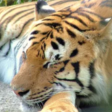

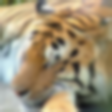

In [15]:
def example_transformed(transform: Callable[[torch.Tensor], torch.Tensor], image_id: int = 510, seed: int = 42) -> None:
    torch.manual_seed(seed)
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[image_id]
    # added displaying before transform to easily see what the transform does
    display_image_tensor(img)
    with torch.no_grad():
        img = transform(img)
    display_image_tensor(img)


def benchmark_transform(transform: v2.Transform) -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "train", transform=transform)
    dataset = Subset(dataset, range(2500))
    dataloader = get_dataloader(dataset, batch_size=256, num_workers=0)
    for _image_batch, _label_batch in tqdm(dataloader):
        pass


example_transformed(v2.GaussianBlur(kernel_size=25, sigma=2.0), 513)

#### 1a: Blur
Implement a transformation that blurs the image (any method that makes the image visually smoother in all directions is fine).<br>
The transform should be parameterized by strength (from roughly 1 meaning no/minimal blurring to 100 meaning the image becomes unrecognizable to humans).<br>
For task 1a specifically, do not use any library beyond `torch.*` and python built-ins (in particular, do not use `torchvision`'s `GaussianBlur`).<br>

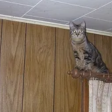

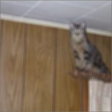

In [16]:
def blur(x: torch.Tensor, strength: int = 10) -> torch.Tensor:
    assert 1 <= strength <= 100, f"Expected 1 ≤ strength ≤ 100, got {strength}."

    ### BEGIN SOLUTION
    *B, C, H, W = x.shape
    data_type = x.dtype
    scale = 1/1000
    size = min(W, H)
    scale = strength * scale
    # the higher the strength, the bigger the kernel, the more blurred transformation
    # scale chosen arbitrary that strength = 100 blurs image a lot and strength = 1 does nothing
    padding = int(size * scale)
    kernel_size = 2 * padding + 1
    aug = nn.AvgPool2d(kernel_size = kernel_size, padding = padding, stride=1)
    out = aug(x)
    assert (*B, C, H, W) == out.shape
    assert data_type == out.dtype

    ### END SOLUTION
    return out

example_transformed(blur, 507)

In [17]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(blur)]))

100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


#### 1b: Pixelize
Implement a transformation that averages blocks of `block_height x block_width` pixels, as in the example below.

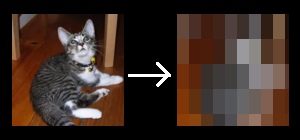

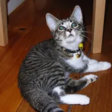

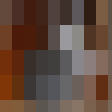

In [18]:
def pixelize(x: torch.Tensor, block_height: int = 8, block_width: int = 8) -> torch.Tensor:
    assert 1 <= block_height and 1 <= block_width, f"Expected ≥1, got {block_height=}, {block_width=}."
    ### BEGIN SOLUTION
    *B, C, H, W = x.shape
    data_type = x.dtype

    pad_h = (block_height - H % block_height) % block_height
    pad_w = (block_width - W % block_width) % block_width

    padded_x = F.pad(x,(0,pad_w,0,pad_h))

    *B_p, C_p, H_p, W_p = padded_x.shape
    # changing shapes to make calculations faster
    x_reshaped = padded_x.view(*B_p,C_p,H_p//block_height,block_height,W_p// block_width, block_width)
    means = x_reshaped.mean((-1,-3), keepdim=True)
    res = means.expand(*B,C_p,H_p//block_height,block_height,W_p // block_width, block_width).reshape(*B,C,H_p, W_p)
    out = res[...,:H,:W]


    assert (*B, C, H, W) == out.shape
    assert out.dtype == data_type
    ### END SOLUTION
    return out


example_transformed(lambda x: pixelize(x, 25, 12), 510)

In [19]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(pixelize)]))

100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


#### 1c: Noise

Implement a transformation that adds noise (same on each channel, up to normalization constants) to an image.<br>
Any kind of noise like that is fine, but it should be parameterized by noise strength (from 1 unnoticeable to 100 unrecognizable) and grain size (roughly in pixels), as in the four examples below.<br>

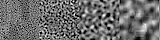

In [20]:
def noise(x: torch.Tensor, strength: int = 25, grain_size: int = 5) -> torch.Tensor:
    assert 1 <= strength <= 100, f"Expected 1 ≤ strength ≤ 100, got {strength}."
    assert 1 <= grain_size <= 100, f"Expected 1 ≤ grain_size ≤ 100, got {grain_size}."
    ### BEGIN SOLUTION
    *B, C, H, W = x.shape
    data_type = x.dtype
    torch.manual_seed(42)

    # so that strength = 1 make literally no change
    scalar = (strength - 1) / 30
    std = x.std() * scalar
    # dividing here by 1000 means that block height ranges from about 1 - 12
    scale_grain = grain_size / 1000
    block_height = int(H * scale_grain) + 1
    block_width = int(W * scale_grain) + 1

    pad_h = (block_height - H % block_height) % block_height
    pad_w = (block_width - W % block_width) % block_width

    x_padded = F.pad(x, (0,pad_w, 0, pad_h))
    *B_p, C_p, H_p, W_p = x_padded.shape
    shape = *B_p, C_p, H_p // block_height, block_height, W_p // block_width, block_width
    x_reshaped = x_padded.view(shape)

    noise = torch.randn((*B_p, C_p, H_p // block_height, 1, W_p // block_width, 1)) * std
    noise_expanded = noise.expand(shape)
    out = x_reshaped + noise_expanded
    out = out.reshape(*B_p, C_p, H_p, W_p)
    out = out[...,:H,:W]

    # output should remain normalized, since input normalized and adding variable from normal distribution - random noise, doesnt
    # change distibution
    assert (*B, C, H, W) == out.shape
    assert out.dtype == data_type
    ### END SOLUTION
    return out

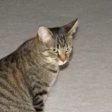

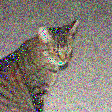

In [21]:
example_transformed(noise, 506)

In [22]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(noise)]))

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


## Task 2: Comparing augmentations

Focus on the readability of the presented results.

Note: to use transforms defined in a notebook, you will have to call `evaluate()` with `use_workers=False`<br>
(this is because functions are pickled by reference, and those defined in a notebook cannot be imported by workers spawned by a dataloader;<br>
other workarounds include writing a Python module e.g. with `%%writefile file.py`, or using the `cloudpickle` package, but we prefer to keep it simple here).

#### Side note: lambdas in for loops

Since in this task it may be useful to use lots of lambdas (to change default parameters in your transformations),<br>
we would like to warn about one potential pitfall here.<br>

One 'gotcha' in Python is that 'for' variables (and similar blocks) are not scoped to the loop body,<br>
they continue with the value from the last iteration.

In [90]:
def example() -> None:
    for i in range(3):
        for j in range(3):
            pass
        print(j)

example()

2
2
2


This is sometimes useful and mostly benign, but we may overlook using the wrong variable.

Another gotcha is that closures in Python (lambdas or def-s using variables from external scopes)<br>
are *late-binding*, meaning variables are captured by reference,<br>
so especially together with the previous gotcha, we get a probably-not-so-intuitive result:

In [91]:
def example() -> None:
    funcs = [(lambda x: x + a) for a in range(3)]
    for f in funcs:
        print(f(0))


example()

2
2
2


Use `lambda x, a=a: f(x,a)` or `functools.partial(f, a=a)` to capture by value instead.

(A linter like [ruff](https://docs.astral.sh/ruff/) will warn you about both gotchas, by detecting e.g. [unused loop variables](https://docs.astral.sh/ruff/rules/unused-loop-control-variable/) and [loop variables used in closures](https://docs.astral.sh/ruff/rules/function-uses-loop-variable/), unfortunately there is no easy way to use them in Colab).

#### 2a: On vanilla model

Compare how `get_model()` performs on inputs from the `val` dataset, when transformed with your transformations (one at a time) or with `v2.GaussianBlur`, using different transform parameters.
(Use each transformation after `get_eval_transform()`, as in the benchmarks above.)

Plot the results. The total time taken by computations for this subtask must not exceed 10 minutes (on Colab GPU)<br>
(use fewer than 100 calls to evaluate(); if running on CPU, expect less than 40 minutes).<br>
Discuss the results in 2-4 sentences.

In [92]:
### BEGIN SOLUTION


def plotter(x, results, labels, x_label, title):
    plt.figure(figsize=(8, 6))

    # Check if results and labels have the same length
    assert len(results) == len(labels)

    for result, label in zip(results, labels):
        plt.plot(x, result, marker='o', linestyle='-', label=label)

    plt.xlabel(x_label, fontsize=12)
    plt.ylabel("Evaluation Metric (e.g., Accuracy)", fontsize=12)
    plt.title(title, fontsize=14)

    plt.grid(True)
    plt.legend(fontsize=10)
    plt.show()


In [93]:
from math import sqrt
from torchvision import transforms

SEED = 42
torch.manual_seed(SEED)
# number of params per transformation
params_size = 16

strength_blur = torch.linspace(1,100,params_size,dtype = torch.int)

strength_noise = torch.linspace(1,100,int(sqrt(params_size)), dtype = torch.int)
grain_size = torch.linspace(1,100,params_size // len(strength_noise),dtype = torch.int)

block_h = torch.linspace(1,100,int(sqrt(params_size)),dtype = torch.int)
block_w = torch.linspace(1,100,params_size // len(block_h) ,dtype = torch.int)

kernel_size_gaus = torch.linspace(1,30,int(sqrt(params_size)), dtype = torch.int)
std_gaus = torch.linspace(0.1, 10, params_size // len(kernel_size_gaus), dtype = torch.float32)

my_blur_results = []
noise_results = []
noise_labels = []
pixelize_results = []
pixelize_labels = []
gaus_results = []
gaus_labels = []


def my_benchmark() -> None:
    model = get_model(eval=True)
    # blur
    print("MY BLUR")
    for s in strength_blur:
      dataset = ImageFolder(MINI_IMAGENET_PATH / "val",
                          transform=v2.Compose([get_eval_transform(),
                            v2.Lambda(lambda x, s=s: blur(x, strength=s))]))
      my_blur_results.append(evaluate(model, dataset ,use_workers=False))

    # noise
    print("NOISE")
    for g in grain_size:
      res = []
      for s in strength_noise:
        dataset = ImageFolder(MINI_IMAGENET_PATH / "val",
                          transform=v2.Compose([get_eval_transform(),
                            v2.Lambda(lambda x, s=s,g=g: noise(x, strength=s, grain_size=g))]))
        res.append(evaluate(model, dataset ,use_workers=False))
      noise_labels.append(f"grain_size = {g}")
      noise_results.append(res)

    # pixelize
    print("PIXELIZE")

    for h in block_h:
      res = []
      for w in block_w:
        dataset = ImageFolder(MINI_IMAGENET_PATH / "val",
                          transform=v2.Compose([get_eval_transform(),
                            v2.Lambda(lambda x,h=h,w=w: pixelize(x, block_height=h, block_width=w))]))
        res.append(evaluate(model, dataset ,use_workers=False))
      pixelize_labels.append(f"height = {h}")
      pixelize_results.append(res)

    # gausian Blur
    print("GAUSSIAN BLUR")
    for s in std_gaus:
      res = []
      s = s.item()
      for k in kernel_size_gaus:
        k = k.item()
        if k % 2 == 0:
          k -= 1
        dataset = ImageFolder(MINI_IMAGENET_PATH / "val",
                          transform=v2.Compose([get_eval_transform(),
                                                 v2.GaussianBlur(kernel_size=k, sigma=s)]))
        # here we can already use workers
        res.append(evaluate(model, dataset))
      gaus_labels.append(f"std = {s}")
      gaus_results.append(res)



In [94]:
my_benchmark()

MY BLUR


eval: 100%|██████████| 4/4 [00:17<00:00,  4.37s/it, accuracy=24.1 %]


NOISE


eval: 100%|██████████| 4/4 [00:04<00:00,  1.25s/it, accuracy=11.2 %]


PIXELIZE


eval: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, accuracy=10.3 %]


GAUSSIAN BLUR


eval: 100%|██████████| 4/4 [00:11<00:00,  2.98s/it, accuracy=24.9 %]


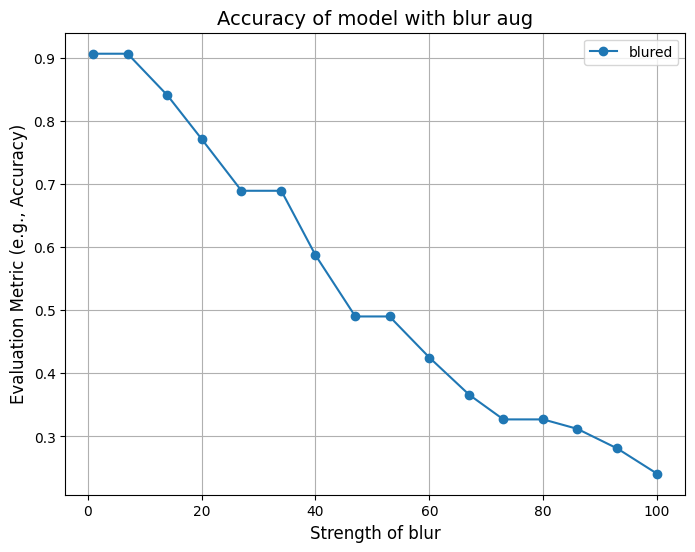

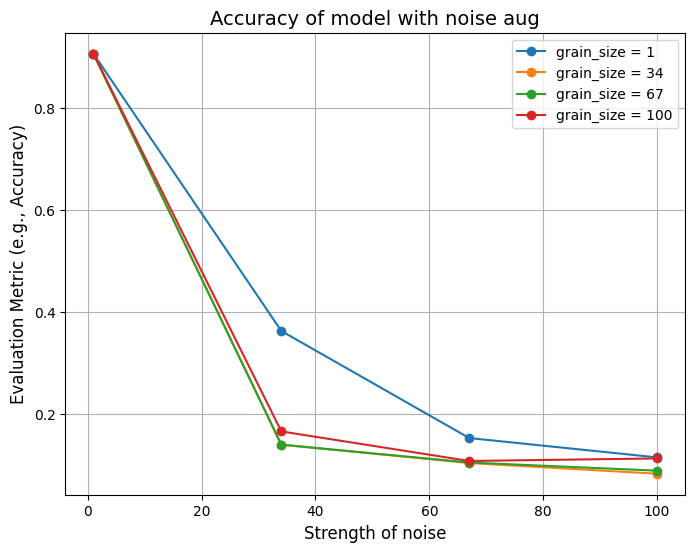

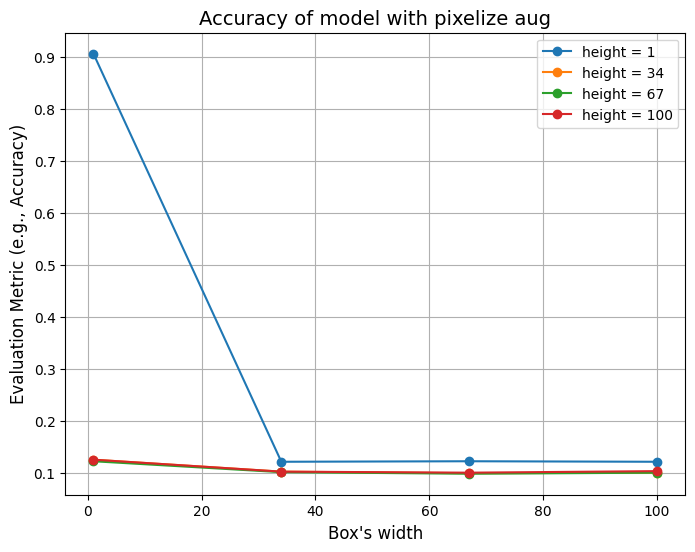

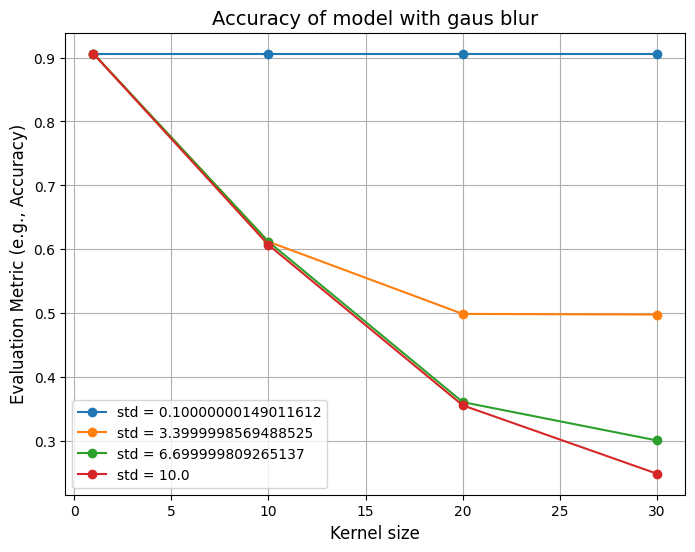

In [95]:
plotter(strength_blur,[my_blur_results],["blured"], "Strength of blur", "Accuracy of model with blur aug")
plotter(strength_noise, noise_results, noise_labels,"Strength of noise", "Accuracy of model with noise aug")
plotter(block_w, pixelize_results, pixelize_labels,"Box's width", "Accuracy of model with pixelize aug")
plotter(kernel_size_gaus, gaus_results, gaus_labels,"Kernel size", "Accuracy of model with gaus blur")


# MY BLUR
# accuracy of the model drops linearly - makes sense since kernel is increased linearly accroding to strength
# some information still remains since accuracy drops to about 0.25 and with random should be about 0.1

# NOISE
# only noise with grain size = 1 behaves sligtly different, but in general all versions decrease a lot with noise strength
# makes sense since std of noise is increased with strength

# PIXELIZE
# with boxes bigger we average all the values and since they are pretty big already for height/width = 34
# we get really steep decrease in accuracy. Only box with height/width = 1 has high accuracy - nothing changes to the images
# in this case

# GAUSSIAN BLUR
# the higher the std the more steeply accuracy decreases. Interestingly std = 0.1 makes almost no difference.
# Movewer as expected with greater kernel size all versions loose accuarcy (apart from std = 0.1).

# If given more time I would check and plot more parameters for instance for pixelize
# since now the graph doesnt look really interesting, while I wanted to cover entire range of parameters' values - (1-100)


### END SOLUTION

#### 2b: Fine-tuning

Consider the following set of transformations: `{v2.Identity(), noise(strength=25, grain_size=3), v2.GaussianBlur(kernel_size=7, sigma=5)}`.

Compare how models fine-tuned for 3 epochs with each augmentation from that set<br>
(one at a time, using `Trainer(extra_augmentation=..., n_epochs=3)`, with `use_workers=False` if `noise` is used)<br>
performs on val with each augmentation from that set, and on the alt dataset with zero augmentations.<br>
We don't expect computations to take more than 20 minutes in total, for this subtask (on Colab GPU; CPU is too slow for fine-tuning, ~20min per epoch).

Present the `3 x 4` results in a table. Discuss the results in 1-2 sentences.

In [96]:
### BEGIN SOLUTION
from copy import deepcopy

# training
model = get_model(eval=True)

augmentations = {
    "Identity": v2.Identity(),
    "Noise": v2.Lambda(lambda x: noise(x, strength=25, grain_size=3)),
    "GaussianBlur": v2.GaussianBlur(kernel_size=7, sigma=5),
}


results = {}
# Train models
trained_models = {}
for name, aug in augmentations.items():
  print(f"augmentation = {name}")
  trainer = Trainer(extra_augmentation=aug, n_epochs=3, use_workers=(name != "Noise"))
  model_t = deepcopy(model)
  res = trainer.train(model_t)
  print(res)
  trained_models[name] = model_t



augmentation = Identity
val=90.6 %	alt=42.9 %	


Train epoch   1: 100%|██████████| 79/79 [01:03<00:00,  1.24it/s, train-acc=82.9 %, lr=0.0002]


val=93.8 %	alt=50.9 %	


Train epoch   2: 100%|██████████| 79/79 [00:55<00:00,  1.41it/s, train-acc=87.8 %, lr=0.000194]


val=94.6 %	alt=52.0 %	


Train epoch   3: 100%|██████████| 79/79 [00:56<00:00,  1.40it/s, train-acc=89.1 %, lr=0.000188]


val=95.0 %	alt=50.2 %	
{'val': [0.906, 0.938, 0.946, 0.95], 'alt': [0.42892857142857144, 0.5092857142857142, 0.5203571428571429, 0.5017857142857143]}
augmentation = Noise
val=90.6 %	alt=42.9 %	


Train epoch   1: 100%|██████████| 79/79 [01:59<00:00,  1.51s/it, train-acc=74.2 %, lr=0.0002]


val=91.2 %	alt=50.4 %	


Train epoch   2: 100%|██████████| 79/79 [02:09<00:00,  1.64s/it, train-acc=82.4 %, lr=0.000194]


val=93.0 %	alt=50.8 %	


Train epoch   3: 100%|██████████| 79/79 [02:00<00:00,  1.52s/it, train-acc=85.0 %, lr=0.000188]


val=93.4 %	alt=50.5 %	
{'val': [0.906, 0.912, 0.93, 0.934], 'alt': [0.42892857142857144, 0.5039285714285714, 0.5082142857142857, 0.505]}
augmentation = GaussianBlur
val=90.6 %	alt=42.9 %	


Train epoch   1: 100%|██████████| 79/79 [01:07<00:00,  1.17it/s, train-acc=75.6 %, lr=0.0002]


val=92.7 %	alt=54.6 %	


Train epoch   2: 100%|██████████| 79/79 [01:02<00:00,  1.26it/s, train-acc=82.3 %, lr=0.000194]


val=93.6 %	alt=53.4 %	


Train epoch   3: 100%|██████████| 79/79 [01:01<00:00,  1.29it/s, train-acc=83.9 %, lr=0.000188]


val=94.4 %	alt=53.1 %	
{'val': [0.906, 0.927, 0.936, 0.944], 'alt': [0.42892857142857144, 0.5457142857142857, 0.5342857142857143, 0.5310714285714285]}


In [97]:
import pandas as pd

datasets = {}

for name, aug in augmentations.items():
  validation_set = ImageFolder(MINI_IMAGENET_PATH / "val",
                            transform=v2.Compose([get_eval_transform(),
                              aug]))
  datasets[name + "_dataset"] = validation_set
datasets["alt_dataset"] = alt_test_dataset

row_names = augmentations.keys()
col_names = datasets.keys()
df = pd.DataFrame(index=row_names, columns=col_names)

for name, aug in augmentations.items():
  model_t = trained_models[name]
  for set_name, dataset in datasets.items():
    print(f"model trained with augmenation = {name} and dataset name augmnentation= {set_name}")
    val_score = evaluate(model_t, dataset, use_workers=(set_name != "Noise_dataset"))
    df.loc[name,set_name] = val_score


model trained with augmenation = Identity and dataset name augmnentation= Identity_dataset


eval: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it, accuracy=95.0 %]


model trained with augmenation = Identity and dataset name augmnentation= Noise_dataset


eval: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it, accuracy=60.6 %]


model trained with augmenation = Identity and dataset name augmnentation= GaussianBlur_dataset


eval: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it, accuracy=80.6 %]


model trained with augmenation = Identity and dataset name augmnentation= alt_dataset


eval: 100%|██████████| 11/11 [00:11<00:00,  1.09s/it, accuracy=50.2 %]


model trained with augmenation = Noise and dataset name augmnentation= Identity_dataset


eval: 100%|██████████| 4/4 [00:08<00:00,  2.08s/it, accuracy=93.4 %]


model trained with augmenation = Noise and dataset name augmnentation= Noise_dataset


eval: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it, accuracy=78.1 %]


model trained with augmenation = Noise and dataset name augmnentation= GaussianBlur_dataset


eval: 100%|██████████| 4/4 [00:08<00:00,  2.21s/it, accuracy=78.4 %]


model trained with augmenation = Noise and dataset name augmnentation= alt_dataset


eval: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it, accuracy=50.5 %]


model trained with augmenation = GaussianBlur and dataset name augmnentation= Identity_dataset


eval: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it, accuracy=94.4 %]


model trained with augmenation = GaussianBlur and dataset name augmnentation= Noise_dataset


eval: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it, accuracy=56.1 %]


model trained with augmenation = GaussianBlur and dataset name augmnentation= GaussianBlur_dataset


eval: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it, accuracy=85.4 %]


model trained with augmenation = GaussianBlur and dataset name augmnentation= alt_dataset


eval: 100%|██████████| 11/11 [00:11<00:00,  1.09s/it, accuracy=53.1 %]


In [98]:
print(df)
# rows are models fine tuned with given transform, while columns are dataset on which model are tested
# all models perform well on Identity dataset - which makes sense, and similarly badly on alt_dataset
# while on Noise and GausianBlur datasets definitely the best performing model is the one fine tuned on
# the respective augmentation, which also seems reasonable.

### END SOLUTION

             Identity_dataset Noise_dataset GaussianBlur_dataset alt_dataset
Identity                 0.95         0.606                0.806    0.501786
Noise                   0.934         0.781                0.784       0.505
GaussianBlur            0.944         0.561                0.854    0.531071


## Adversarial image modification with PGD

One method to improve robustness, other than augmentations, is to train on adversarial examples: images that are altered with small perturbations to fool the model.
Here's a typical implementation.

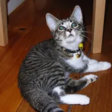

label=5 (cat)
Prediction: 5 (cat)


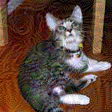

Prediction: 7 (clock)


In [23]:
def adversarialPGD(
    model: torch.nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    epsilon: float = 4 / 255,
    alpha: float = 2 / 255,
    n_iters: int = 1,
    random_init: bool = False,
) -> torch.Tensor:
    """
    Find an input xᵃᵈᵛ within x±ε pushing `model(xᵃᵈᵛ)` away from y (maximizing loss, unless alpha is negative).

    Uses 'Projective Gradient Descent' with learning rate `alpha` and `n_iters` iterations, as introduced in:
    Madry et al., "Towards Deep Learning Models Resistant to Adversarial Attacks", ICRL 2018
    https://openreview.net/forum?id=rJzIBfZAb

    Assumes x is 0..1-valued and keeps it in these bounds (i.e., it expects unnormalized images).
    """
    was_training = model.training
    model.eval()
    x = x.clone().detach()
    with torch.no_grad():
        x_min = torch.clamp(x - epsilon, min=0)
        x_max = torch.clamp(x + epsilon, max=1)

        if random_init:
            x = x + torch.empty_like(x).uniform_(-epsilon, epsilon)
            x.clamp_(x_min, x_max)

    for _ in range(n_iters):
        x.requires_grad = True
        logits = model(x)
        loss = torch.nn.CrossEntropyLoss()(logits, y)
        with torch.no_grad():
            x_grad = torch.autograd.grad(loss, x)[0]
            # We could also:
            #   loss.backward()
            #   x_grad = x.grad.detach()
            # but then we'd nedd to temporarily set requires_grad=False on all model parameters.
            x = x.detach() + alpha * x_grad.sign()
            x.clamp_(x_min, x_max)
            x = x.detach()

    if was_training:
        model.train()
    return x.requires_grad_(False)


def example(device="cuda") -> None:
    model = get_model(eval=True).to(device)

    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[510]
    display_image_tensor(img)
    print(f"{label=} ({dataset.classes[label]})")

    img = img.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)
    pred = model(img)[0].argmax().item()
    print(f"Prediction: {pred} ({dataset.classes[pred]})")

    adv_img = normalize(adversarialPGD(model, unnormalize(img), label, epsilon=20 / 255, n_iters=100))
    display_image_tensor(adv_img[0])
    pred = model(adv_img)[0].argmax().item()
    print(f"Prediction: {pred} ({dataset.classes[pred]})")


example()


## Task 3: AdvProp

Training on adversarial examples unfortunately tends to decrease accuracy on plain (unmodified) images a lot.<br>
The authors of [Adversarial Examples Improve Image Recognition](https://arxiv.org/abs/1911.09665) hypothesize that<br>
this is because adversarial examples (and the model activations they induce) follow different distributions.<br>
They propose addressing that by using auxilliary batch-norm-s for the adversarial images.

#### 3a: Implementation
Read the paper and implement this technique. Note that:
* Parameters (weights and biases of the affine transform applied after normalizing) should be the same for plain and adversarial images; only the running mean and variance (the buffers) are distinct.
* During evaluation, the plain batch-norms should be used.
* Add the two losses from plain and adversarial images using weights that sum up to one, specifically: `0.75 * plain_loss + 0.25 * adversarial_loss`.
* You should not need to alter this and other hyperparameters; use the defaults of `Trainer.__init__()` and `adversarialPGD` (they are different than suggested in the paper, but work better in our case).
* See `get_model()` for an example of how layers can be replaced. You can assume all batch-norms are instances of `torch.nn.BatchNorm2d` (with `affine=True`, `track_running_stats=True`, and non-null `momentum`).

In [24]:
### BEGIN SOLUTION

import torch
import torch.nn as nn

class DualBatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True):
        super(DualBatchNorm2d, self).__init__()
        self.bn_clean = nn.BatchNorm2d(num_features, eps, momentum, affine, track_running_stats)
        self.bn_adv = nn.BatchNorm2d(num_features, eps, momentum, affine, track_running_stats)

        if affine:
            self.bn_adv.weight = self.bn_clean.weight
            self.bn_adv.bias = self.bn_clean.bias

        self.use_adv = False

    def forward(self, x):
        if self.use_adv:
            return self.bn_adv(x)
        else:
            return self.bn_clean(x)

    def set_mode(self, use_adv):
        """Set the mode: use_adv=True for adversarial, False for clean."""
        self.use_adv = use_adv

new_model = get_model()
replacements = []


for parent_module in new_model.modules():
  for name, layer in parent_module.named_children():
    if isinstance(layer, nn.BatchNorm2d):
        # Replace with DualBatchNorm2d
        num_features = layer.num_features
        new_bn = DualBatchNorm2d(
            num_features,
            layer.eps,
            layer.momentum,
            layer.affine,
            layer.track_running_stats,
        )
        # as indicated on Slack, we copy already existing running mean and var
        new_bn.bn_clean.running_mean = layer.running_mean
        new_bn.bn_adv.running_mean = layer.running_mean
        new_bn.bn_clean.running_var = layer.running_var
        new_bn.bn_adv.running_var = layer.running_var

        replacements.append((parent_module, name, new_bn))

for parent_module, name, new_bn in replacements:
    setattr(parent_module, name, new_bn)

def set_bn_mode(model, use_adv):
    for module in model.modules():
        if isinstance(module, DualBatchNorm2d):
            module.set_mode(use_adv)

### END SOLUTION

In [32]:
class AdvPropTrainer(Trainer):
    def __init__(
        self,
        lr: float = 2e-4,
        weight_decay: float = 3e-5,
        batch_norm_momentum: float | None = 0.002,
        n_epochs: int = 10,
        device: str = "cuda",
        n_iters: int = 1,
        epsilon: float = 4 / 255,
        alpha: float = 2 / 255,
        adv_ratio: float = 0.25,
    ):
        super().__init__(
            lr=lr, weight_decay=weight_decay, batch_norm_momentum=batch_norm_momentum, n_epochs=n_epochs, device=device
        )
        self.n_iters = n_iters
        self.epsilon = epsilon
        self.alpha = alpha
        self.adv_ratio = adv_ratio

    ### BEGIN SOLUTION
    def train(self, model: torch.nn.Module) -> dict[str, list[float]]:
      model = model.to(self.device)

      if self.batch_norm_momentum is not None:
          # Default torch.nn.BatchNorm2D.momentum is 0.1, but it's often too high.
          for m in model.modules():
              if isinstance(m, BATCH_NORM_TYPES):
                  m.momentum = self.batch_norm_momentum

      train_dataloader = self.get_train_dataloader()
      eval_dataloaders = self.get_eval_dataloaders()
      optimizer, lr_scheduler = self.get_optimizer_and_scheduler(model.parameters())

      results = {k: [] for k in eval_dataloaders.keys()}
      set_bn_mode(model,False)
      for k, v in self.do_evaluations(model, eval_dataloaders).items():
          results[k].append(v)

      for epoch in range(1, self.n_epochs + 1):
          self.train_epoch(model, train_dataloader, optimizer, epoch)
          lr_scheduler.step()

          set_bn_mode(model,False)
          for k, v in self.do_evaluations(model, eval_dataloaders).items():
              results[k].append(v)

      return results

    def train_epoch(
        self, model: torch.nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, epoch: int
    ) -> None:
        model.train()
        n_correct_adv = 0
        n_correct_plain = 0
        n_total = 0
        progress_bar = tqdm(dataloader, desc=f"Train epoch {epoch:>3}")
        for image_batch, label_batch in progress_bar:
            image_batch, label_batch = image_batch.to(self.device), label_batch.to(self.device)
            image_batch_adv = normalize(adversarialPGD(model, unnormalize(image_batch), label_batch, epsilon=self.epsilon, n_iters=self.n_iters))

            set_bn_mode(model,False)
            optimizer.zero_grad()
            logits_batch_plain = model(image_batch)
            loss_sum = (1 - self.adv_ratio) * torch.nn.CrossEntropyLoss()(logits_batch_plain, label_batch)

            set_bn_mode(model,True)
            logits_batch_adv = model(image_batch_adv)
            loss_sum += self.adv_ratio * torch.nn.CrossEntropyLoss()(logits_batch_adv, label_batch)
            loss_sum.backward()
            optimizer.step()

            with torch.no_grad():
                n_correct_plain += (logits_batch_plain.argmax(dim=1) == label_batch).sum().item()
                n_correct_adv += (logits_batch_adv.argmax(dim=1) == label_batch).sum().item()
                n_total += len(label_batch)
            accuracy_plain = n_correct_plain / n_total
            accuracy_adv = n_correct_adv / n_total

            progress_bar.set_postfix({
                "train-acc on plain images": f"{accuracy_plain * 100:.1f} %",
                "train-acc on adv images": f"{accuracy_adv * 100:.1f} %",
                "lr": optimizer.param_groups[0]["lr"]
            })




    ### END SOLUTION

#### 3b: Evaluation

Compare Trainer and AdvPropTrainer (using default hyperparameters, 10 epochs, in particular).<br>
(One training with Trainer / AdvPropTrainer takes roughly 15 / 20 minutes on colab GPU, respectively).<br>
Discuss the results in 1-3 sentences (consider proposing what could be tested further, with more time).

In [34]:
### BEGIN SOLUTION
model = get_model()
torch.manual_seed(seed)

# n_epochs = 10 by default
print("Normal model")
trainer = Trainer()
model_t = deepcopy(model)
res = trainer.train(model_t)

print("Adv Prop")
trainer_adv = AdvPropTrainer()
model_t_adv = deepcopy(model)
res = trainer_adv.train(model_t_adv)

# it turns out that normal model has better val score than AdvPropTrainer
# Moreover it seems that each epochs runs slightly quicker, which makes sense,
# since we additionally need to change images and run each batch 2 times (plain images and adversary)

# what could be checked is - finetuning the Trainer, adjusting ratio between adverary and normal loss
# in the final loss

# On Adv Prop model train acc on plain images and adv images increases however, on adv is sligthly smaller, which is intuitive, due to ratio and
# fine tuning nature - it start from lower point

### END SOLUTION

Normal model
val=90.3 %	alt=43.2 %	


Train epoch   1: 100%|██████████| 79/79 [01:26<00:00,  1.10s/it, train-acc=65.4 %, lr=0.0002]


val=89.3 %	alt=54.5 %	


Train epoch   2: 100%|██████████| 79/79 [01:11<00:00,  1.10it/s, train-acc=75.7 %, lr=0.000194]


val=90.8 %	alt=54.8 %	


Train epoch   3: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s, train-acc=78.1 %, lr=0.000188]


val=91.9 %	alt=54.1 %	


Train epoch   4: 100%|██████████| 79/79 [01:10<00:00,  1.12it/s, train-acc=79.3 %, lr=0.000183]


val=93.0 %	alt=54.4 %	


Train epoch   5: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s, train-acc=80.9 %, lr=0.000177]


val=92.7 %	alt=54.1 %	


Train epoch   6: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s, train-acc=81.8 %, lr=0.000172]


val=94.0 %	alt=54.3 %	


Train epoch   7: 100%|██████████| 79/79 [01:13<00:00,  1.07it/s, train-acc=82.0 %, lr=0.000167]


val=94.1 %	alt=52.7 %	


Train epoch   8: 100%|██████████| 79/79 [01:11<00:00,  1.10it/s, train-acc=82.7 %, lr=0.000162]


val=94.3 %	alt=54.5 %	


Train epoch   9: 100%|██████████| 79/79 [01:10<00:00,  1.11it/s, train-acc=83.3 %, lr=0.000157]


val=94.2 %	alt=55.2 %	


Train epoch  10: 100%|██████████| 79/79 [01:10<00:00,  1.11it/s, train-acc=83.7 %, lr=0.000152]


val=95.4 %	alt=54.6 %	
Adv Prop
val=90.3 %	alt=43.2 %	


Train epoch   1: 100%|██████████| 79/79 [01:30<00:00,  1.15s/it, train-acc on plain images=64.6 %, train-acc on adv images=33.1 %, lr=0.0002]


val=92.3 %	alt=55.4 %	


Train epoch   2: 100%|██████████| 79/79 [01:24<00:00,  1.07s/it, train-acc on plain images=74.2 %, train-acc on adv images=43.2 %, lr=0.000194]


val=91.7 %	alt=55.0 %	


Train epoch   3: 100%|██████████| 79/79 [01:27<00:00,  1.10s/it, train-acc on plain images=77.3 %, train-acc on adv images=56.7 %, lr=0.000188]


val=92.3 %	alt=55.4 %	


Train epoch   4: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc on plain images=79.3 %, train-acc on adv images=61.7 %, lr=0.000183]


val=92.7 %	alt=55.1 %	


Train epoch   5: 100%|██████████| 79/79 [01:26<00:00,  1.10s/it, train-acc on plain images=80.1 %, train-acc on adv images=65.6 %, lr=0.000177]


val=92.2 %	alt=54.2 %	


Train epoch   6: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc on plain images=81.4 %, train-acc on adv images=68.5 %, lr=0.000172]


val=92.8 %	alt=53.5 %	


Train epoch   7: 100%|██████████| 79/79 [01:26<00:00,  1.10s/it, train-acc on plain images=81.5 %, train-acc on adv images=68.9 %, lr=0.000167]


val=93.4 %	alt=52.4 %	


Train epoch   8: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc on plain images=82.5 %, train-acc on adv images=70.1 %, lr=0.000162]


val=92.7 %	alt=50.7 %	


Train epoch   9: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc on plain images=83.0 %, train-acc on adv images=71.5 %, lr=0.000157]


val=93.4 %	alt=50.1 %	


Train epoch  10: 100%|██████████| 79/79 [01:26<00:00,  1.09s/it, train-acc on plain images=83.6 %, train-acc on adv images=72.2 %, lr=0.000152]


val=93.4 %	alt=49.6 %	


## Task 4: SparseTopK

Another technique to improve robustness against style and pattern changes was proposed in
[Emergence of Shape Bias in CNNs through Activation Sparsity](https://openreview.net/forum?id=QzcZb3fWmW)
(you do not need to read the paper).
The idea is simple: in between some layers, enforce activation sparsity by zeroing out all but the top say 20% activations (by absolute value).
The hope is that the strong activations, which we keep, encode the more generalizable shape information.

More formally `SparseTopK`, for a fixed fraction $k$ like $20\%$, should be a module that for an input $x \in \mathbb{R}^{C \times H \times W}$ outputs:
$$ \begin{align*}
    x_{\text{out}}[c,h,w] &= x[c,h,w]\quad &&\text{ if } |x[c,h,w]| \geq \text{top-k-percentile}(x[c,:,:]) \\
                          &= 0 \quad &&\text{ otherwise}
\end{align*} $$

Your task is to:
* implement such a module below (for inputs of shape `(batch_size, C, H, W)`),
* run the example once (for 10 epochs),
* shortly discuss the result (one sentence).

In [35]:
class SparseTopK(torch.nn.Module):
    def __init__(self, k: float):
        super().__init__()
        self.k = k
        assert 0 <= k <= 1, f"Expected 0 ≤ k ≤ 1, got {k}."

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ### BEGIN SOLUTION
        B, C, H, W = x.shape
        changed_x = x.view((B,C,-1))
        abs_x = torch.abs(changed_x)
        quantile = torch.quantile(abs_x,q=1-self.k, dim= -1, keepdim=True)
        mask =  abs_x >= quantile
        changed_x *= mask
        changed_x = changed_x.view(B,C,H,W)
        assert changed_x.shape == x.shape
        return changed_x


def example_sparse() -> None:
    model = get_model()
    # The paper tests on ResNet18 and suggests inserting one SparseTopK(0.2) module after the second layer.
    # We'll do something similar for our model, EfficientNetB0.
    model.features[1][0].block.insert(3, SparseTopK(0.2))

    Trainer().train(model)


example_sparse()

val=76.6 %	alt=31.9 %	


Train epoch   1: 100%|██████████| 79/79 [01:20<00:00,  1.01s/it, train-acc=51.7 %, lr=0.0002]


val=85.8 %	alt=51.5 %	


Train epoch   2: 100%|██████████| 79/79 [01:20<00:00,  1.01s/it, train-acc=63.7 %, lr=0.000194]


val=84.6 %	alt=53.7 %	


Train epoch   3: 100%|██████████| 79/79 [01:18<00:00,  1.00it/s, train-acc=68.2 %, lr=0.000188]


val=84.9 %	alt=54.1 %	


Train epoch   4: 100%|██████████| 79/79 [01:13<00:00,  1.07it/s, train-acc=70.3 %, lr=0.000183]


val=84.8 %	alt=55.0 %	


Train epoch   5: 100%|██████████| 79/79 [01:11<00:00,  1.10it/s, train-acc=71.6 %, lr=0.000177]


val=86.8 %	alt=55.6 %	


Train epoch   6: 100%|██████████| 79/79 [01:11<00:00,  1.10it/s, train-acc=72.8 %, lr=0.000172]


val=89.4 %	alt=56.0 %	


Train epoch   7: 100%|██████████| 79/79 [01:12<00:00,  1.09it/s, train-acc=73.9 %, lr=0.000167]


val=88.6 %	alt=56.3 %	


Train epoch   8: 100%|██████████| 79/79 [01:10<00:00,  1.12it/s, train-acc=75.1 %, lr=0.000162]


val=90.2 %	alt=56.1 %	


Train epoch   9: 100%|██████████| 79/79 [01:10<00:00,  1.11it/s, train-acc=75.7 %, lr=0.000157]


val=90.7 %	alt=55.6 %	


Train epoch  10: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s, train-acc=76.1 %, lr=0.000152]


val=90.8 %	alt=54.6 %	


In [ ]:
# model starts with significantly worse performance than normal model - finetuning on model with
# no activations zeroed out artificially.
# Even though it manages to reach over 90% it is still worse than normal model
# after 10 epochs of training (visble in 3b task). It might happen that sparseK
# model would catch up with accuracy of standard model given more time to train
# We only fine tune already existing model, maybe it could be better
# if it was training from scratch using SparseK

#  However on alt set it performs similarly about 55%

`### BEGIN SOLUTION (discussion)`


`### END SOLUTION`